In [45]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

## Hyper params:
BATCH_SIZE = 32
SEED = 36
IMG_SIZE = 224
PATCH_SIZE = 16
NUM_PATHCES = IMG_SIZE/PATCH_SIZE
assert IMG_SIZE % PATCH_SIZE == 0, "Image size must be divisible by patch size"
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"

root = 'data'

In [20]:
#FashionMNIST

trnsf = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor(),
])

train_ds = torchvision.datasets.FashionMNIST(
      root = root,
      train=True,
      transform=trnsf,
      download=True,
)

val_ds = torchvision.datasets.FashionMNIST(
    root=root,
    train=False,
    transform=trnsf,
    download=True,
)

def get_dataloader(ds):
  return DataLoader(
      ds,
      batch_size=BATCH_SIZE,
      shuffle=True,
      pin_memory=True,
      num_workers=2,
  )

train_dl = get_dataloader(train_ds)
val_dl = get_dataloader(val_ds)

In [21]:
num_classes = train_ds.classes
num_classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


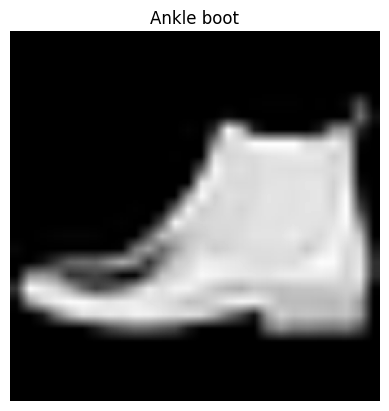

In [22]:
for x,y in train_dl:
  plt.imshow(x[0].permute(1,2,0),cmap="gray")
  plt.title(num_classes[y[0]])
  plt.axis(False)
  break

In [24]:
height = 224
width =224
color_channels= 1
patch_size =16

number_of_pathces = int((height*width)/patch_size**2)
number_of_pathces

196

In [29]:
embedding_layer_input = (height,width,color_channels)
embedding_layer_output = (number_of_pathces,patch_size**2*color_channels)
embedding_layer_input,embedding_layer_output

((224, 224, 1), (196, 256))

In [38]:
image = x[0]
print(image,"\n",image.shape)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]) 
 torch.Size([1, 224, 224])


In [42]:
class PatchEmbedding(nn.Module):
  def __init__(self,in_channels=1,patch_size = 16,embedding_dim = 256):
    super().__init__()
    self.patcher = nn.Conv2d(
        in_channels = in_channels,
        out_channels = embedding_dim,
        kernel_size = patch_size,
        stride = patch_size,
        padding=0,
    )
    self.flatten = nn.Flatten(start_dim=2)

  def forward(self,x):
    assert x.shape[-1] % self.patcher.kernel_size[0] == 0, " input image size must  be divisible by pathc"
    x = self.patcher(x)
    x = self.flatten(x)

    return x.permute(0,2,1)

In [43]:
patchify = PatchEmbedding()
x_ = patchify(x)
print(x.shape)
print(x_.shape)

torch.Size([32, 1, 224, 224])
torch.Size([32, 196, 256])


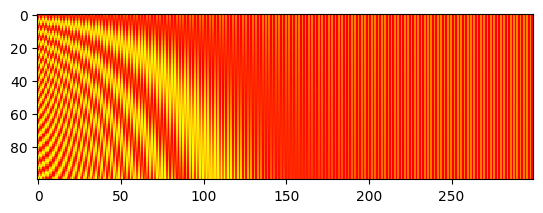

In [73]:
def get_positional_embeddings(sequence_length, embedding_dimension):
    result = torch.ones(BATCH_SIZE,sequence_length, embedding_dimension)
    for i in range(sequence_length):
        for j in range(embedding_dimension):
            result[:,i,j] = np.sin(i / (10000 ** (j / embedding_dimension))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / embedding_dimension)))
    return result

plt.imshow(get_positional_embeddings(100, 300)[1].squeeze(0), cmap="autumn_r", interpolation="nearest")
plt.show()

In [74]:
sequence_length = x_.shape[1]
embedding_dimension = x_.shape[2]

position_embeddings = get_positional_embeddings(sequence_length,embedding_dimension)
position_embeddings.shape,x_.shape

(torch.Size([32, 196, 256]), torch.Size([32, 196, 256]))

In [78]:
class MHSFAB(nn.Module):
  def __init__(self,
               embedding_dim = 256,
               num_heads = 16 ,
               attn_dropout: float=0):
    super().__init__()
    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)
    self.attn = nn.MultiheadAttention(
        embed_dim = embedding_dim,
        num_heads = num_heads,
        dropout = attn_dropout,
        batch_first=True,
    )

  def forward(self,x):
    x = self.layer_norm(x)
    attn_output , _ = self.attn(query = x,
                                key=x,
                                value=x,
                                need_weights=False)
    return attn_output


In [79]:
patch_and_position_embedding = x_ + position_embeddings
multihead_self_attention_block = MHSFAB()

patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([32, 196, 256])
Output shape MSA block: torch.Size([32, 196, 256])


In [86]:
class MLPBlock(nn.Module):
  def __init__(self,embedding_dim = 256,mlp_size = 3072,dropout=0.1):
    super().__init__()
    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)
    self.mlp=nn.Sequential(
        nn.Linear(embedding_dim,mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(mlp_size,
                  embedding_dim),
        nn.Dropout(p=dropout),
    )

  def forward(self,x):
    x= self.layer_norm(x)
    x= self.mlp(x)
    return x

In [87]:
mlp_block = MLPBlock()

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([32, 196, 256])
Output shape MLP block: torch.Size([32, 196, 256])
